In [1]:
from PIL import Image, ImageDraw
import pandas as pd
import pyarrow as pa
from tqdm import tqdm, trange, tqdm_notebook
from time import sleep
from math import sqrt
import glob
import os
import re

In [2]:
# The initial release contains only one tile, so lets hardcode its location
# here.  When you have more tiles, you can update this
TILE_X = 7680
TILE_Y = 10240

(start_x, start_y) = (0, 0)
(size_x, size_y) = (512, 512)

cropbox = (start_x, start_y, start_x + size_x, start_y + size_y)

In [3]:
# Get the physical path to the PNG image containing the mask file
def get_mask_path(tile_x, tile_y, mask_type):
    path = 'E:\\work\\canecrushers\\phase-01\\'
    path += f"data\\sentinel-2a-tile-{tile_x}x-{tile_y}y\\masks\\{mask_type}-mask.png"
    #path += f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/masks/{mask_type}-mask.png"
    #path = f'E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\timeseries\'
    return path

mask_path = get_mask_path(TILE_X, TILE_Y, 'sugarcane-region')
print(mask_path)
assert os.path.isfile(mask_path)

E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\masks\sugarcane-region-mask.png


In [4]:
def open_image(path, mode = None, cropbox = None, verbose = True):
    if verbose:
        print(path)
    img = Image.open(path)
    if cropbox is not None:
        img = img.crop(cropbox)
    if mode is not None:
        img = img.convert(mode)
    if verbose:
        print("Format: {0}\nSize: {1}\nMode: {2}".format(img.format, img.size, img.mode))
        (width, height) = img.size
        print('width:',width,'height:',height)
    return img

E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\masks\sugarcane-region-mask.png
Format: None
Size: (512, 512)
Mode: P
width: 512 height: 512


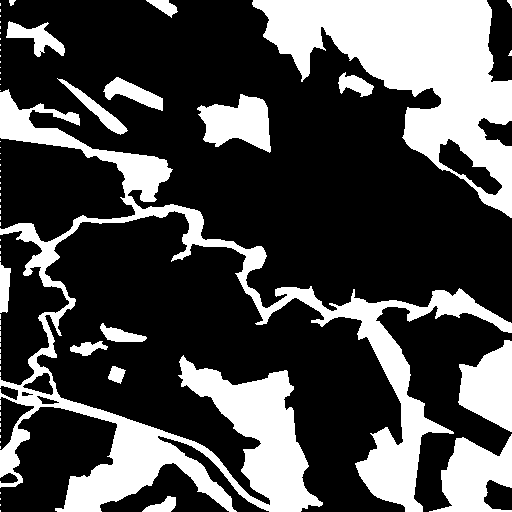

In [5]:
masp = open_image(mask_path, mode = 'P', cropbox = cropbox)
masp

In [6]:
# Get a list of all the image tiles for a specific x,y coordinate
# for the specified band
def get_timeseries_image_paths(tile_x, tile_y, band):
    path = 'E:\\work\\canecrushers\\phase-01\\'
    path += f"data\\sentinel-2a-tile-{tile_x}x-{tile_y}y\\timeseries\\{tile_x}-{tile_y}-{band}*.png"
    #print(path)
    images = glob.glob(path)
    return images

In [7]:
tci_list = get_timeseries_image_paths(TILE_X, TILE_Y, 'TCI')
tci_list[-1]

'E:\\work\\canecrushers\\phase-01\\data\\sentinel-2a-tile-7680x-10240y\\timeseries\\7680-10240-TCI-2019-08-09.png'

In [8]:
def last_date_in_path(path):
    return re.findall('\d{4}-\d{2}-\d{2}',path)[-1]

test_path = tci_list[-1]
print(test_path)
print(last_date_in_path(test_path))

E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\timeseries\7680-10240-TCI-2019-08-09.png
2019-08-09


In [9]:
b_name_list = [f'B{b:02d}' for b in range(1,13)]
b_path_lol = [get_timeseries_image_paths(TILE_X, TILE_Y, b) for b in b_name_list]
b_path_lol[-5][-1]

'E:\\work\\canecrushers\\phase-01\\data\\sentinel-2a-tile-7680x-10240y\\timeseries\\7680-10240-B08-2019-08-09.png'

In [10]:
def read_img_pixel_values(tile_x, tile_y, date, *args):
    """ return array of arrays 
        one array for each pixel (10m X 10 m), containing 
        an array for each spectrum value for the pixel
    """
    int_max = 2**15-1
    for img in (args):
        assert img.size == args[0].size
    (width, height) = args[0].size
    #print('width',width,'height',height)

    pixl_list = [img.load() for img in args]

    result_list = []
    for x in range(0, width):
        for y in range(0, height):
            val_list = [tile_x, tile_y, x, y, date]
            for pix in pixl_list:
                val = pix[x,y]
                if isinstance(val, tuple):
                    val_list.extend(val)
                else:
                    val_list.append(val)
            result_list.append(val_list)
    return result_list

In [11]:
def write_to_excel(df, file_name, sheet_name='sheet1'):
    writer = pd.ExcelWriter(file_name, engine='xlsxwriter')
    df.to_excel(writer, sheet_name=sheet_name)
    writer.save()

In [12]:
# see for spectral band information:
# https://en.wikipedia.org/wiki/Sentinel-2
columns = ['tile_x','tile_y', 'x','y', 'date', 'mask', 'red','green','blue', ]
columns.extend([f'B{b:02d}' for b in range(1,13)])
print(columns)

['tile_x', 'tile_y', 'x', 'y', 'date', 'mask', 'red', 'green', 'blue', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12']


In [13]:
#for tci_path, b_path_list in tqdm(list(zip(tci_list,b_path_lol))):
assert len(tci_list) == len(b_path_lol[0])
(tile_x, tile_y) = (TILE_X, TILE_Y)
for day_no in trange(len(tci_list)):
    tci_path = tci_list[day_no]
    date = last_date_in_path(tci_path)
    b_path_list = [b_path_list[day_no] for b_path_list in b_path_lol]

    tci_img = open_image(tci_path, cropbox = cropbox, verbose=False)
    b_img_list = [open_image(b_path, cropbox = cropbox, verbose=False) for b_path in b_path_list]

    data = read_img_pixel_values(tile_x, tile_y, date, masp, tci_img, *b_img_list)

    df = pd.DataFrame(columns=columns, data=data)
    # apply a very very simple havested rules
    df['clouds'] = df.apply(lambda df : df.red == df.green and df.red == df.blue, axis=1)
    df['havested'] = df.apply(lambda df : df.red > df.green, axis=1)

    # Calculate Indices:
    # https://support.micasense.com/hc/en-us/articles/227837307-An-overview-of-the-available-layers-and-indices-in-Atlas
    # https://support.micasense.com/hc/en-us/articles/226531127-Creating-agricultural-indices-NDVI-NDRE-from-an-Atlas-GeoTIFF-in-QGIS-
    # https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
    # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/
    # NDVI ref: https://medium.com/analytics-vidhya/satellite-imagery-analysis-with-python-3f8ccf8a7c32

    # NDVI - Normalised Difference Vegetation Index (NDVI)
    #  = (NIR - RED) / (NIR + RED)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_361.js
    df['NDVI'] = df.apply(lambda df : int(10000 * (float(df.B08) - float(df.B04)) / (df.B08 + df.B04)) , axis=1)

    # GNDVI - Green Normalized Difference NDVI
    #  = (NIR - GREEN)/(NIR + GREEN)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gTm9ybWFsaXplZCBEaWZmZXJlbmNlIE5JUi9HcmVlbiBHcmVlbiBORFZJIChhYmJydi4gR05EVkkpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKE5JUi1HUkVFTikvKE5JUitHUkVFTikKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD00MDEKLy8KCmxldCBpbmRleCA9IChCMDggLSBCMDMpIC8gKEIwOCArIEIwMyk7CmxldCBtaW4gPSAtMC44OTsKbGV0IG1heCA9IDAuODk7CmxldCB6ZXJvID0gMC4wOwoKLy8gY29sb3JCbGVuZCB3aWxsIHJldHVybiBhIGNvbG9yIHdoZW4gdGhlIGluZGV4IGlzIGJldHdlZW4gbWluIGFuZCBtYXggYW5kIHdoaXRlIHdoZW4gaXQgaXMgbGVzcyB0aGFuIG1pbi4KLy8gVG8gc2VlIGJsYWNrIHdoZW4gaXQgaXMgbW9yZSB0aGFuIG1heCwgdW5jb21tZW50IHRoZSBsYXN0IGxpbmUgb2YgY29sb3JCbGVuZC4KLy8gVGhlIG1pbi9tYXggdmFsdWVzIHdlcmUgY29tcHV0ZWQgYXV0b21hdGljYWxseSBhbmQgbWF5IGJlIHBvb3JseSBzcGVjaWZpZWQsIGZlZWwgZnJlZSB0byBjaGFuZ2UgdGhlbSB0byB0d2VhayB0aGUgZGlzcGxheWVkIHJhbmdlLgovLyBUaGlzIGluZGV4IGNyb3NzZXMgemVybywgc28gYSBkaXZlcmdpbmcgY29sb3IgbWFwIGlzIHVzZWQuIFRvIHR3ZWFrIHRoZSB2YWx1ZSBvZiB0aGUgYnJlYWsgaW4gdGhlIGNvbG9yIG1hcCwgY2hhbmdlIHRoZSB2YXJpYWJsZSAnemVybycuCgpsZXQgdW5kZXJmbG93X2NvbG9yID0gWzEsIDEsIDFdOwpsZXQgbG93X2NvbG9yID0gWzIwOC8yNTUsIDg4LzI1NSwgMTI2LzI1NV07CmxldCBoaWdoX2NvbG9yID0gWzI0MS8yNTUsIDIzNC8yNTUsIDIwMC8yNTVdOwpsZXQgemVyb19jb2xvciA9IFswLCAxNDcvMjU1LCAxNDYvMjU1XTsKbGV0IG92ZXJmbG93X2NvbG9yID0gWzAsIDAsIDBdOwoKcmV0dXJuIGNvbG9yQmxlbmQoaW5kZXgsIFttaW4sIG1pbiwgemVybywgbWF4XSwKWwoJdW5kZXJmbG93X2NvbG9yLAoJbG93X2NvbG9yLAoJemVyb19jb2xvciwgLy8gZGl2ZXJnZW50IHN0ZXAgYXQgemVybwoJaGlnaF9jb2xvciwKCS8vb3ZlcmZsb3dfY29sb3IgLy8gdW5jb21tZW50IHRvIHNlZSBvdmVyZmxvd3MKXSk7DQo%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_401.js
    df['GNDVI'] = df.apply(lambda df : int(10000 * (float(df.B08) - float(df.B03)) / (df.B08 + df.B03)) , axis=1)

    # RDVI - Relative Normalised Difference Vegetation Index (RDVI)
    #  = 2*(NIR - RED) / sqrt(NIR + RED)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gUmVub3JtYWxpemVkIERpZmZlcmVuY2UgVmVnZXRhdGlvbiBJbmRleCAgIChhYmJydi4gUkRWSSkKLy8KLy8gR2VuZXJhbCBmb3JtdWxhOiAoODAwbm0gLSA2NzBubSkgL3NxcnQoODAwbm0gKyA2NzBubSkwLjUKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD03NgovLwoKbGV0IGluZGV4ID0gKEIwOCAtIEIwNCkgLyBNYXRoLnNxcnQoQjA4ICsgQjA0KSAqIDAuNTsKbGV0IG1pbiA9IC0wLjI2NjsKbGV0IG1heCA9IDAuMjY2OwpsZXQgemVybyA9IDAuMDsKCi8vIGNvbG9yQmxlbmQgd2lsbCByZXR1cm4gYSBjb2xvciB3aGVuIHRoZSBpbmRleCBpcyBiZXR3ZWVuIG1pbiBhbmQgbWF4IGFuZCB3aGl0ZSB3aGVuIGl0IGlzIGxlc3MgdGhhbiBtaW4uCi8vIFRvIHNlZSBibGFjayB3aGVuIGl0IGlzIG1vcmUgdGhhbiBtYXgsIHVuY29tbWVudCB0aGUgbGFzdCBsaW5lIG9mIGNvbG9yQmxlbmQuCi8vIFRoZSBtaW4vbWF4IHZhbHVlcyB3ZXJlIGNvbXB1dGVkIGF1dG9tYXRpY2FsbHkgYW5kIG1heSBiZSBwb29ybHkgc3BlY2lmaWVkLCBmZWVsIGZyZWUgdG8gY2hhbmdlIHRoZW0gdG8gdHdlYWsgdGhlIGRpc3BsYXllZCByYW5nZS4KLy8gVGhpcyBpbmRleCBjcm9zc2VzIHplcm8sIHNvIGEgZGl2ZXJnaW5nIGNvbG9yIG1hcCBpcyB1c2VkLiBUbyB0d2VhayB0aGUgdmFsdWUgb2YgdGhlIGJyZWFrIGluIHRoZSBjb2xvciBtYXAsIGNoYW5nZSB0aGUgdmFyaWFibGUgJ3plcm8nLgoKbGV0IHVuZGVyZmxvd19jb2xvciA9IFsxLCAxLCAxXTsKbGV0IGxvd19jb2xvciA9IFsyMDgvMjU1LCA4OC8yNTUsIDEyNi8yNTVdOwpsZXQgaGlnaF9jb2xvciA9IFsyNDEvMjU1LCAyMzQvMjU1LCAyMDAvMjU1XTsKbGV0IHplcm9fY29sb3IgPSBbMCwgMTQ3LzI1NSwgMTQ2LzI1NV07CmxldCBvdmVyZmxvd19jb2xvciA9IFswLCAwLCAwXTsKCnJldHVybiBjb2xvckJsZW5kKGluZGV4LCBbbWluLCBtaW4sIHplcm8sIG1heF0sClsKCXVuZGVyZmxvd19jb2xvciwKCWxvd19jb2xvciwKCXplcm9fY29sb3IsIC8vIGRpdmVyZ2VudCBzdGVwIGF0IHplcm8KCWhpZ2hfY29sb3IsCgkvL292ZXJmbG93X2NvbG9yIC8vIHVuY29tbWVudCB0byBzZWUgb3ZlcmZsb3dzCl0pOw0K&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_76.js
    df['RDVI'] = df.apply(lambda df : int(100 * 2 * (float(df.B08) - float(df.B04)) / sqrt(df.B08 + df.B04)) , axis=1)

    # RBNDVI - Red Blue Normalised Difference Vegetation Index (NDVI)
    #  = (NIR - RED -BLUE) / (NIR + RED + BLUE)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gUmVkLUJsdWUgTkRWSSAgKGFiYnJ2LiBSQk5EVkkpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKE5JUi0oUkVEK0JMVUUpKS8oTklSKyhSRUQrQkxVRSkpCi8vCi8vIFVSTCBodHRwczovL3d3dy5pbmRleGRhdGFiYXNlLmRlL2RiL3NpLXNpbmdsZS5waHA%2Fc2Vuc29yX2lkPTk2JnJzaW5kZXhfaWQ9MTg3Ci8vCgpsZXQgaW5kZXggPSAoQjA4IC0gKEIwNCArIEIwMikpIC8gKEIwOCArIChCMDQgKyBCMDIpKTsKbGV0IG1pbiA9IC0wLjkzOTsKbGV0IG1heCA9IDAuNTI5OwpsZXQgemVybyA9IDAuMDsKCi8vIGNvbG9yQmxlbmQgd2lsbCByZXR1cm4gYSBjb2xvciB3aGVuIHRoZSBpbmRleCBpcyBiZXR3ZWVuIG1pbiBhbmQgbWF4IGFuZCB3aGl0ZSB3aGVuIGl0IGlzIGxlc3MgdGhhbiBtaW4uCi8vIFRvIHNlZSBibGFjayB3aGVuIGl0IGlzIG1vcmUgdGhhbiBtYXgsIHVuY29tbWVudCB0aGUgbGFzdCBsaW5lIG9mIGNvbG9yQmxlbmQuCi8vIFRoZSBtaW4vbWF4IHZhbHVlcyB3ZXJlIGNvbXB1dGVkIGF1dG9tYXRpY2FsbHkgYW5kIG1heSBiZSBwb29ybHkgc3BlY2lmaWVkLCBmZWVsIGZyZWUgdG8gY2hhbmdlIHRoZW0gdG8gdHdlYWsgdGhlIGRpc3BsYXllZCByYW5nZS4KLy8gVGhpcyBpbmRleCBjcm9zc2VzIHplcm8sIHNvIGEgZGl2ZXJnaW5nIGNvbG9yIG1hcCBpcyB1c2VkLiBUbyB0d2VhayB0aGUgdmFsdWUgb2YgdGhlIGJyZWFrIGluIHRoZSBjb2xvciBtYXAsIGNoYW5nZSB0aGUgdmFyaWFibGUgJ3plcm8nLgoKbGV0IHVuZGVyZmxvd19jb2xvciA9IFsxLCAxLCAxXTsKbGV0IGxvd19jb2xvciA9IFsyMDgvMjU1LCA4OC8yNTUsIDEyNi8yNTVdOwpsZXQgaGlnaF9jb2xvciA9IFsyNDEvMjU1LCAyMzQvMjU1LCAyMDAvMjU1XTsKbGV0IHplcm9fY29sb3IgPSBbMCwgMTQ3LzI1NSwgMTQ2LzI1NV07CmxldCBvdmVyZmxvd19jb2xvciA9IFswLCAwLCAwXTsKCnJldHVybiBjb2xvckJsZW5kKGluZGV4LCBbbWluLCBtaW4sIHplcm8sIG1heF0sClsKCXVuZGVyZmxvd19jb2xvciwKCWxvd19jb2xvciwKCXplcm9fY29sb3IsIC8vIGRpdmVyZ2VudCBzdGVwIGF0IHplcm8KCWhpZ2hfY29sb3IsCgkvL292ZXJmbG93X2NvbG9yIC8vIHVuY29tbWVudCB0byBzZWUgb3ZlcmZsb3dzCl0pOw0K&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_187.js
    df['RBNDVI'] = df.apply(lambda df : int(10000 * (2*float(df.B08) - float(df.B04) - float(df.B02)) / (2*df.B08 + df.B04 + df.B02)) , axis=1)

    # LCI - Leaf Chlorophyll Index
    #  = (NIR - REDE)/(NIR + REDE)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gTGVhZiBDaGxvcm9waHlsbCBJbmRleCAgKGFiYnJ2LiBMQ0kpCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKFs4NTBdLVs3MTBdKS8oWzg1MF0rWzY4MF0pCi8vCi8vIFVSTCBodHRwczovL3d3dy5pbmRleGRhdGFiYXNlLmRlL2RiL3NpLXNpbmdsZS5waHA%2Fc2Vuc29yX2lkPTk2JnJzaW5kZXhfaWQ9MTA5Ci8vCgpsZXQgaW5kZXggPSAoQjA4IC0gQjA1KSAvIChCMDggKyBCMDQpOwpsZXQgbWluID0gLTIuNzk4OwpsZXQgbWF4ID0gMC43MzU7CmxldCB6ZXJvID0gMC4wOwoKLy8gY29sb3JCbGVuZCB3aWxsIHJldHVybiBhIGNvbG9yIHdoZW4gdGhlIGluZGV4IGlzIGJldHdlZW4gbWluIGFuZCBtYXggYW5kIHdoaXRlIHdoZW4gaXQgaXMgbGVzcyB0aGFuIG1pbi4KLy8gVG8gc2VlIGJsYWNrIHdoZW4gaXQgaXMgbW9yZSB0aGFuIG1heCwgdW5jb21tZW50IHRoZSBsYXN0IGxpbmUgb2YgY29sb3JCbGVuZC4KLy8gVGhlIG1pbi9tYXggdmFsdWVzIHdlcmUgY29tcHV0ZWQgYXV0b21hdGljYWxseSBhbmQgbWF5IGJlIHBvb3JseSBzcGVjaWZpZWQsIGZlZWwgZnJlZSB0byBjaGFuZ2UgdGhlbSB0byB0d2VhayB0aGUgZGlzcGxheWVkIHJhbmdlLgovLyBUaGlzIGluZGV4IGNyb3NzZXMgemVybywgc28gYSBkaXZlcmdpbmcgY29sb3IgbWFwIGlzIHVzZWQuIFRvIHR3ZWFrIHRoZSB2YWx1ZSBvZiB0aGUgYnJlYWsgaW4gdGhlIGNvbG9yIG1hcCwgY2hhbmdlIHRoZSB2YXJpYWJsZSAnemVybycuCgpsZXQgdW5kZXJmbG93X2NvbG9yID0gWzEsIDEsIDFdOwpsZXQgbG93X2NvbG9yID0gWzIwOC8yNTUsIDg4LzI1NSwgMTI2LzI1NV07CmxldCBoaWdoX2NvbG9yID0gWzI0MS8yNTUsIDIzNC8yNTUsIDIwMC8yNTVdOwpsZXQgemVyb19jb2xvciA9IFswLCAxNDcvMjU1LCAxNDYvMjU1XTsKbGV0IG92ZXJmbG93X2NvbG9yID0gWzAsIDAsIDBdOwoKcmV0dXJuIGNvbG9yQmxlbmQoaW5kZXgsIFttaW4sIG1pbiwgemVybywgbWF4XSwKWwoJdW5kZXJmbG93X2NvbG9yLAoJbG93X2NvbG9yLAoJemVyb19jb2xvciwgLy8gZGl2ZXJnZW50IHN0ZXAgYXQgemVybwoJaGlnaF9jb2xvciwKCS8vb3ZlcmZsb3dfY29sb3IgLy8gdW5jb21tZW50IHRvIHNlZSBvdmVyZmxvd3MKXSk7DQo%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_109.js
    df['LCI'] = df.apply(lambda df : int(10000 * (float(df.B08) - float(df.B05)) / (df.B08 + df.B05)) , axis=1)

    # LAI - Leaf Area Index
    #  = (REDE - RED)/(REDE + RED)
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3231680/
    df['LAI'] = df.apply(lambda df : int(10000 * (float(df.B05) - float(df.B04)) / (df.B05 + df.B04)) , axis=1)
    
    # GLI - Green Leaf Index
    #  = (2*GREEN - RED - BLUE)/(2*GREEN + RED + BLUE)
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3231680/
    df['GLI'] = df.apply(lambda df : int(10000 * (float(df.B05) - float(df.B04)) / (df.B05 + df.B04)) , axis=1)

    # SCI - Soil Composition Index
    #  = (SWIR - NIR)/(SWIR + NIR)
    # https://apps.sentinel-hub.com/sentinel-playground/?source=S2&lat=-20.83757591134921&lng=148.7277603149414&zoom=15&preset=CUSTOM&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2019-03-01%7C2019-09-19&atmFilter=&showDates=false&evalscript=Ly8KLy8gU29pbCBDb21wb3NpdGlvbiBJbmRleCAgKGFiYnJ2LiApCi8vCi8vIEdlbmVyYWwgZm9ybXVsYTogKFsxNjAwOjE3MDBdLVs3NjA6ODYwXSkvKFsxNjAwOjE3MDBdK1s3NjA6ODYwXSkKLy8KLy8gVVJMIGh0dHBzOi8vd3d3LmluZGV4ZGF0YWJhc2UuZGUvZGIvc2ktc2luZ2xlLnBocD9zZW5zb3JfaWQ9OTYmcnNpbmRleF9pZD04OAovLwoKbGV0IGluZGV4ID0gKEIxMSAtIEIwOCkgLyAoQjExICsgQjA4KTsKbGV0IG1pbiA9IC0wLjg5OwpsZXQgbWF4ID0gMC44OTsKbGV0IHplcm8gPSAwLjA7CgovLyBjb2xvckJsZW5kIHdpbGwgcmV0dXJuIGEgY29sb3Igd2hlbiB0aGUgaW5kZXggaXMgYmV0d2VlbiBtaW4gYW5kIG1heCBhbmQgd2hpdGUgd2hlbiBpdCBpcyBsZXNzIHRoYW4gbWluLgovLyBUbyBzZWUgYmxhY2sgd2hlbiBpdCBpcyBtb3JlIHRoYW4gbWF4LCB1bmNvbW1lbnQgdGhlIGxhc3QgbGluZSBvZiBjb2xvckJsZW5kLgovLyBUaGUgbWluL21heCB2YWx1ZXMgd2VyZSBjb21wdXRlZCBhdXRvbWF0aWNhbGx5IGFuZCBtYXkgYmUgcG9vcmx5IHNwZWNpZmllZCwgZmVlbCBmcmVlIHRvIGNoYW5nZSB0aGVtIHRvIHR3ZWFrIHRoZSBkaXNwbGF5ZWQgcmFuZ2UuCi8vIFRoaXMgaW5kZXggY3Jvc3NlcyB6ZXJvLCBzbyBhIGRpdmVyZ2luZyBjb2xvciBtYXAgaXMgdXNlZC4gVG8gdHdlYWsgdGhlIHZhbHVlIG9mIHRoZSBicmVhayBpbiB0aGUgY29sb3IgbWFwLCBjaGFuZ2UgdGhlIHZhcmlhYmxlICd6ZXJvJy4KCmxldCB1bmRlcmZsb3dfY29sb3IgPSBbMSwgMSwgMV07CmxldCBsb3dfY29sb3IgPSBbMjA4LzI1NSwgODgvMjU1LCAxMjYvMjU1XTsKbGV0IGhpZ2hfY29sb3IgPSBbMjQxLzI1NSwgMjM0LzI1NSwgMjAwLzI1NV07CmxldCB6ZXJvX2NvbG9yID0gWzAsIDE0Ny8yNTUsIDE0Ni8yNTVdOwpsZXQgb3ZlcmZsb3dfY29sb3IgPSBbMCwgMCwgMF07CgpyZXR1cm4gY29sb3JCbGVuZChpbmRleCwgW21pbiwgbWluLCB6ZXJvLCBtYXhdLApbCgl1bmRlcmZsb3dfY29sb3IsCglsb3dfY29sb3IsCgl6ZXJvX2NvbG9yLCAvLyBkaXZlcmdlbnQgc3RlcCBhdCB6ZXJvCgloaWdoX2NvbG9yLAoJLy9vdmVyZmxvd19jb2xvciAvLyB1bmNvbW1lbnQgdG8gc2VlIG92ZXJmbG93cwpdKTsNCg%3D%3D&evalscripturl=https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/indexdb/id_88.js
    df['SCI'] = df.apply(lambda df : int(10000 * (float(df.B11) - float(df.B08)) / (df.B11 + df.B08)) , axis=1)

    df.to_parquet(f'image_values_{tile_x}_{tile_y}_{date}.snappy.parquet')
    #df.to_csv(f'image_values_{tile_x}_{tile_y}_{date}.csv.gzip', compression='gzip')


100%|██████████| 71/71 [2:06:48<00:00, 106.69s/it]  


In [14]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
print(df[df.x==5][df.y==5])

E:\Python\Anaconda3.7.3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


      tile_x  tile_y  x  y        date  mask  red  green  blue   B01   B02  \
2565  7680    10240   5  5  2019-08-09  0     50   66     68    2332  1862   

       B03   B04   B05   B06  B07   B08   B09  B10   B11   B12  clouds  \
2565  1826  1380  2146  3614  0    4332  1406  20   4018  2102  False    

      havested  NDVI  GNDVI    RDVI  RBNDVI  LCI   LAI   GLI  SCI  
2565  False     5168  4069   781182  4554    33   2172  2172 -376  


In [15]:
df.dtypes

tile_x      int64 
tile_y      int64 
x           int64 
y           int64 
date        object
mask        int64 
red         int64 
green       int64 
blue        int64 
B01         int64 
B02         int64 
B03         int64 
B04         int64 
B05         int64 
B06         int64 
B07         int64 
B08         int64 
B09         int64 
B10         int64 
B11         int64 
B12         int64 
clouds      bool  
havested    bool  
NDVI        int64 
GNDVI       int64 
RDVI        int64 
RBNDVI      int64 
LCI         int64 
LAI         int64 
GLI         int64 
SCI         int64 
dtype: object

In [26]:
import geopandas as gpd
lots_path = 'E:\work\canecrushers\lots\Cadastral_data_QLD_CADASTRE_DCDB_PindiPindi.formatted.geo.json'

In [28]:
lots_gpd = gpd.read_file(lots_path)
lots_gpd.dtypes

LOT           object 
PLAN          object 
LOTPLAN       object 
SEG_NUM       int64  
PAR_NUM       int64  
SEGPAR        int64  
PAR_IND       int64  
LOT_AREA      float64
EXCL_AREA     float64
LOT_VOLUME    float64
SURV_IND      object 
TENURE        object 
PRC           int64  
PARISH        object 
COUNTY        object 
LAC           int64  
SHIRE_NAME    object 
FEAT_NAME     object 
ALIAS_NAME    object 
LOC           int64  
LOCALITY      object 
PARCEL_TYP    object 
COVER_TYP     object 
ACC_CODE      object 
CA_AREA_SQ    float64
O_SHAPE_AR    float64
O_SHAPE_LE    float64
Shape_Leng    float64
Shape_Area    float64
geometry      object 
dtype: object

In [80]:
print(lots_gpd.head(1))

  LOT     PLAN   LOTPLAN  SEG_NUM  PAR_NUM    SEGPAR  PAR_IND  LOT_AREA  \
0  1   C124121  1C124121  37385    2        37385002  0        639810.0   

   EXCL_AREA  LOT_VOLUME SURV_IND    TENURE   PRC          PARISH  \
0  2883.0     0.0         Y        Freehold  6000  No Longer Used   

           COUNTY   LAC       SHIRE_NAME FEAT_NAME ALIAS_NAME   LOC  \
0  No Longer Used  4770  Mackay Regional  None      None       4747   

      LOCALITY       PARCEL_TYP COVER_TYP                 ACC_CODE  \
0  Pindi Pindi  Lot Type Parcel  Base      UPGRADE ADJUSTMENT - 5M   

   CA_AREA_SQ  O_SHAPE_AR  O_SHAPE_LE  Shape_Leng  Shape_Area  \
0  217139.796  0.0         0.0         0.02156     0.000019     

                                                                                                                                                                                                                                                                                                       

In [30]:
lots_gpd[lots_gpd.LOTPLAN=='1C124121'].geometry

0    POLYGON ((148.7046900470001 -20.84646421699995, 148.7045470630001 -20.84679765999994, 148.7036105770001 -20.84898150699996, 148.701105244 -20.84833876799996, 148.6998691340001 -20.84759470799997, 148.6996863630001 -20.84797492599995, 148.6968426630001 -20.84724535, 148.6969558600001 -20.84713450099997, 148.6972626820001 -20.84692003599997, 148.6974556070001 -20.84672809399996, 148.697838143 -20.84659849899998, 148.6982957500001 -20.84629267499997, 148.6986703870001 -20.84614579399994, 148.6987007560001 -20.84597375999994, 148.6986852960001 -20.84587334799994, 148.698624253 -20.84577317499998, 148.69824741 -20.84558060799998, 148.698140532 -20.84553785599996, 148.6980281100001 -20.84545830599995, 148.6977593680001 -20.84529446099998, 148.6976917610001 -20.84505399299996, 148.697838247 -20.84485747699995, 148.698209912 -20.84465846399996, 148.6983619260001 -20.84446845199994, 148.698422648 -20.84436586499993, 148.7046900470001 -20.84646421699995))
4    POLYGON ((148.703798257 -20.84

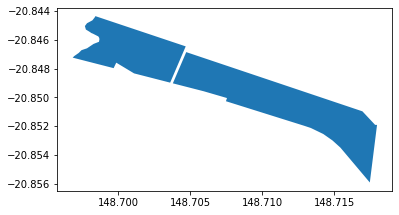

In [56]:
lots_gpd[lots_gpd.LOTPLAN=='1C124121'].plot()

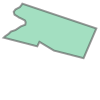

In [70]:
lots_gpd[lots_gpd.LOTPLAN=='1C124121'].geometry[0]

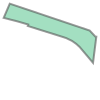

In [71]:
lots_gpd[lots_gpd.LOTPLAN=='1C124121'].geometry[4]

In [73]:
for index, row in lots_gpd[lots_gpd.LOTPLAN=='1C124121'].iterrows():
    print(index, row)

0 LOT           1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
PLAN          C124121   

In [74]:
from shapely.geometry import mapping, shape, Point, Polygon, GeometryCollection

In [95]:
(top, left, bottom, right) = (-20.812410418698178, 148.69443975983441, -20.858263265061037,148.743620498264306)

def px_latlon(top, left, bottom, right, px_width, px_hight):
    """ return array of arrays 
        one array for each pixel (10m X 10 m), containing 
        an array for each spectrum value for the pixel
    """
    
    columns = ['x', 'y', 'lat', 'lon', 'point']

    data = []
    for x in range(0, px_width):
        for y in range(0, px_hight):
            lat = left + (right - left) * (x + 0.5) / px_width
            lon = top + (bottom - top) * (y + 0.5) / px_hight
            pnt = Point(lat, lon)

            data.append([x, y, lat, lon, pnt])
    return gpd.GeoDataFrame(columns=columns, data=data) 

In [97]:
pxlatlon = px_latlon(top, left, bottom, right, 512, 512)
pxlatlon.head(2)

,x,y,lat,lon,point
0,0,0,148.694488,-20.812455,POINT (148.6944877878993 -20.81245519686846)
1,0,1,148.694488,-20.812545,POINT (148.6944877878993 -20.81254475320901)


,x,y,lat,lon
0,0,0,148.694488,-20.812455
